## Classification for DeepQL topics

In [1]:
import keras
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
# %matplotlib inline

from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Model

from keras.models import Model
from keras.layers import Input
from keras.models import load_model
import keras.backend as K
from keras_bert import get_custom_objects

import keras.backend as K
from keras_bert import load_vocabulary
from keras.layers import concatenate, Dropout, Add, Flatten
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import _pickle as pickle

Using TensorFlow backend.


## Configurações Globais

In [2]:
%env epochs 1000
%env base openoffice
%env method deepQL_topics

env: epochs=1000
env: base=openoffice
env: method=deepQL_topics


In [3]:
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000
epochs = int(os.environ['epochs'])

In [4]:
DOMAIN = os.environ['base']
METHOD = '{}_{}'.format(os.environ['method'], epochs)
TOKEN = 'bert'
PREPROCESSING = 'bert'
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
SAVE_PATH = '{}_classification({})'.format(METHOD, DOMAIN)
PRETRAINED_MODEL = 'modelos/model_{}_preprocessing_{}_feature_{}epochs_64batch({}).h5'.format(PREPROCESSING, METHOD, str(epochs), DOMAIN)
TEST_PATH = os.path.join(DIR, 'test_classification.txt')

In [5]:
print("*********")
print("{} for {} epochs in {}".format(METHOD, epochs, DOMAIN))
print("*********")

*********
deepQL_topics_1000 for 1000 epochs in openoffice
*********


In [6]:
print(PRETRAINED_MODEL)

modelos/model_bert_preprocessing_deepQL_topics_1000_feature_1000epochs_64batch(openoffice).h5


In [7]:
K.clear_session()

"""
    A lista de modelos estar disponível no diretorio /modelos
        name:
            - model_baseline_{X}epoch_{Y}steps_({dataset}).h5
            - model_baseline_{X}epoch_{Y}steps_({dataset}).json
    
        Informações adicionais:
            {X} - total de épocas treinada. Ex: 100, 1000
            {Y} - total de steps validados no treino. Ex: 10, 16
            {dataset} - Nome da base testada. Ex: Eclipse, Netbeans, OpenOffice
"""
similarity_model = load_model(PRETRAINED_MODEL, custom_objects=get_custom_objects())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
MAX_SEQUENCE_LENGTH_T = K.int_shape(similarity_model.input[0])[1]
MAX_SEQUENCE_LENGTH_D = K.int_shape(similarity_model.input[1])[1]
MAX_SEQUENCE_LENGTH_I = K.int_shape(similarity_model.input[4])[1]
MAX_SEQUENCE_LENGTH_TOPICS = K.int_shape(similarity_model.input[5])[1]

MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, MAX_SEQUENCE_LENGTH_I, MAX_SEQUENCE_LENGTH_TOPICS

(100, 100, 738, 30)

In [9]:
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [10]:
token_dict = load_vocabulary(vocab_path)

In [11]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, 
                    token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [12]:
baseline.info_dict

{'bug_severity': 6,
 'bug_status': 3,
 'component': 144,
 'priority': 5,
 'product': 41,
 'version': 539}

In [13]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

#### Loading bug ids in memory

In [14]:
experiment.load_ids()
print(len(baseline.bug_ids))

Reading bug ids
98070


#### Loading train bugs

In [15]:
%%time

experiment.load_bugs(TOKEN)


CPU times: user 22.2 s, sys: 1.61 s, total: 23.8 s
Wall time: 23 s


In [16]:
%%time
issues_by_buckets = experiment.get_buckets_for_bugs()
experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')


CPU times: user 102 ms, sys: 4.54 ms, total: 107 ms
Wall time: 100 ms


In [17]:
%%time

bug_train_ids = experiment.get_train_ids(baseline.train_data)

CPU times: user 7 ms, sys: 3.5 ms, total: 10.5 ms
Wall time: 10.4 ms


In [18]:
print(len(bug_train_ids))

104492


In [19]:
%%time

baseline.test_data, baseline.dup_sets_test = experiment.read_test_data_classification(DIR, baseline.bug_set, 
                                                                                      bug_train_ids,
                                                                                     path='test_chronological')

TypeError: read_test_data_classification() missing 1 required positional argument: 'bug_train_ids'

In [20]:
bug_test_ids = experiment.get_test_ids(baseline.test_data)
print(len(bug_test_ids))

8232


In [21]:
baseline.test_data[:10]

[[46081, 46082],
 [13024, 12971],
 [82539, 53252],
 [43113, 41989],
 [112150, 112647],
 [110555, 109535],
 [43361, 41994],
 [84194, 84311],
 [41800, 72467],
 [41800, 70756]]

## Siamese  model

In [22]:
# Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False

In [23]:
bug_t_a = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a')
bug_t_a_token = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a_token')
bug_t_b = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b')
bug_t_b_token = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b_token')

bug_d_a = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a')
bug_d_a_token = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a_token')
bug_d_b = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b')
bug_d_b_token = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b_token')

bug_i_a = Input(shape = (MAX_SEQUENCE_LENGTH_I, ), name = 'info_a')
bug_i_b = Input(shape = (MAX_SEQUENCE_LENGTH_I, ), name = 'info_b')

bug_tp_a = Input(shape = (MAX_SEQUENCE_LENGTH_TOPICS, ), name = 'topic_a')
bug_tp_b = Input(shape = (MAX_SEQUENCE_LENGTH_TOPICS, ), name = 'topic_b')

title_encoder = similarity_model.get_layer('FeatureBERTGenerationModelTitle')
desc_encoder = similarity_model.get_layer('FeatureBERTGenerationModelDescription')
info_encoder = similarity_model.get_layer('FeatureMlpGenerationModel')
topic_encoder = similarity_model.get_layer('FeatureTopicMlpGenerationModel')

model = similarity_model.get_layer('merge_features_in')

# Bug A
bugt_t_a = title_encoder([bug_t_a, bug_t_a_token])
bugt_d_a = desc_encoder([bug_d_a, bug_d_a_token])
bugt_i_a = info_encoder(bug_i_a)
bugt_tp_a = topic_encoder(bug_tp_a)
# Bug B
bugt_t_b = title_encoder([bug_t_b, bug_t_b_token])
bugt_d_b = desc_encoder([bug_d_b, bug_d_b_token])
bugt_i_b = info_encoder(bug_i_b)
bugt_tp_b = topic_encoder(bug_tp_b)

bug_a = model([bugt_i_a, bugt_t_a, bugt_d_a, bugt_tp_a])
bug_b = model([bugt_i_b, bugt_t_b, bugt_d_b, bugt_tp_b])

x = concatenate([bug_a, bug_b], name='bugs') # 

for _ in range(2):
    # propose_bert_triplet
#     x = Dense(128)(x)
#     x = Dropout(0.75)(x)
#     x = Activation('relu')(x)
#     x = BatchNormalization()(x)
    x = Dense(64)(x)
    x = Dropout(0.25)(x)
    x = Activation('tanh')(x)
    #x = BatchNormalization()(x)

output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=[bug_t_a_token, bug_t_a, bug_t_b_token, bug_t_b, 
                          bug_d_a_token, bug_d_a, bug_d_b_token, bug_d_b, 
                          bug_i_a, bug_i_b,
                          bug_tp_a, bug_tp_b], outputs=[output])

#adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_clf.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
info_a (InputLayer)             (None, 738)          0                                            
__________________________________________________________________________________________________
title_a (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
title_a_token (InputLayer)      (None, 100)          0                                            
__________________________________________________________________________________________________
desc_a (InputLayer)             (None, 100)          0                                            
_____________

In [24]:
def batch_classification(train, dup_sets, bug_ids, batch_size, n_neg):
    encoder = LabelEncoder()
    batch_size_normalized = batch_size // 2
    batch_triplet, input_sample, input_pos, input_neg, sim = experiment.batch_iterator_bert(None, 
                                                                                          train, dup_sets, bug_ids, 
                                                                                         batch_size_normalized, n_neg,
                                                                                        issues_by_buckets)
    
    pos = np.full((1, batch_size_normalized), 1)
    neg = np.full((1, batch_size_normalized), 0)
    sim = np.concatenate([pos, neg], -1)[0]
    
    sim = encoder.fit_transform(sim)
    sim = to_categorical(sim)

    title_a = np.concatenate([input_sample['title']['token'], input_sample['title']['token']])
    title_a_seg = np.concatenate([input_sample['title']['segment'], input_sample['title']['segment']])
    title_b = np.concatenate([input_pos['title']['token'], input_neg['title']['token']])
    title_b_seg = np.concatenate([input_pos['title']['segment'], input_neg['title']['segment']])
    desc_a = np.concatenate([input_sample['description']['token'], input_sample['description']['token']])
    desc_a_seg = np.concatenate([input_sample['description']['segment'], input_sample['description']['segment']])
    desc_b = np.concatenate([input_pos['description']['token'], input_neg['description']['token']])
    desc_b_seg = np.concatenate([input_pos['description']['segment'], input_neg['description']['segment']])
    info_a = np.concatenate([input_sample['info'], input_sample['info']])
    info_b = np.concatenate([input_pos['info'], input_neg['info']])
    topic_a = np.concatenate([input_sample['topics'], input_sample['topics']])
    topic_b = np.concatenate([input_pos['topics'], input_neg['topics']])
    
    return title_a, title_a_seg, title_b, title_b_seg, desc_a, desc_a_seg, desc_b, desc_b_seg, info_a, info_b, topic_a, topic_b, sim

def batch_classification_siamese(train, dup_sets, bug_ids, batch_size, n_neg):
    while True:
        title_a, title_a_seg, title_b, title_b_seg, desc_a, desc_a_seg, desc_b, desc_b_seg, info_a, info_b, topic_a, topic_b, sim = batch_classification(train, dup_sets, 
                                                                                     bug_ids, batch_size, n_neg)
        
        yield ({ 'title_a' : title_a, 'title_a_token' : title_a_seg,
                'title_b': title_b, 'title_b_token' : title_b_seg,
                    'desc_a' : desc_a, 'desc_a_token' : desc_a_seg,
                    'desc_b' : desc_b, 'desc_b_token' : desc_b_seg, 
                    'info_a' : info_a, 'info_b' : info_b, 
                    'topic_a' : topic_a, 'topic_b' : topic_b }, sim)

In [25]:
title_a, title_a_seg, title_b, title_b_seg, desc_a, desc_a_seg, desc_b, desc_b_seg, info_a, info_b, topic_a, topic_b, sim = batch_classification(baseline.test_data, 
                                                                             baseline.dup_sets_test,
                                                                             bug_test_ids, 512, 1)

test_validation = ({ 'title_a' : title_a, 'title_a_token' : title_a_seg,
                'title_b': title_b, 'title_b_token' : title_b_seg,
                    'desc_a' : desc_a, 'desc_a_token' : desc_a_seg,
                    'desc_b' : desc_b, 'desc_b_token' : desc_b_seg, 
                    'info_a' : info_a, 'info_b' : info_b,
                    'topic_a' : topic_a, 'topic_b' : topic_b }, sim)

In [26]:
%%time

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

h_clf = model_clf.fit_generator(batch_classification_siamese(baseline.train_data, baseline.dup_sets_train, 
                                                             bug_train_ids, 64, 1), 
                               steps_per_epoch = 10,
                               validation_data=test_validation,
                                             epochs = 100,
#                                              callbacks=[early],
                                             verbose = True) 



Epoch 1/100
10/10 [==============================] - 215s 22s/step - loss: 0.7380 - acc: 0.4859 - val_loss: 0.6991 - val_acc: 0.5273
Epoch 2/100
10/10 [==============================] - 205s 21s/step - loss: 0.7286 - acc: 0.5094 - val_loss: 0.7047 - val_acc: 0.5195
Epoch 3/100
10/10 [==============================] - 205s 21s/step - loss: 0.7296 - acc: 0.5375 - val_loss: 0.6814 - val_acc: 0.5605
Epoch 4/100
10/10 [==============================] - 205s 21s/step - loss: 0.7088 - acc: 0.5172 - val_loss: 0.6824 - val_acc: 0.5586
Epoch 5/100
10/10 [==============================] - 206s 21s/step - loss: 0.7256 - acc: 0.5062 - val_loss: 0.6743 - val_acc: 0.5918
Epoch 6/100
10/10 [==============================] - 205s 21s/step - loss: 0.7019 - acc: 0.5094 - val_loss: 0.6649 - val_acc: 0.6348
Epoch 7/100
10/10 [==============================] - 206s 21s/step - loss: 0.6842 - acc: 0.5734 - val_loss: 0.6634 - val_acc: 0.5859
Epoch 8/100
10/10 [==============================] - 206s 21s/step 

10/10 [==============================] - 206s 21s/step - loss: 0.3767 - acc: 0.8453 - val_loss: 0.4675 - val_acc: 0.7891
Epoch 60/100
10/10 [==============================] - 206s 21s/step - loss: 0.3596 - acc: 0.8313 - val_loss: 0.4343 - val_acc: 0.8066
Epoch 61/100
10/10 [==============================] - 205s 21s/step - loss: 0.3930 - acc: 0.8250 - val_loss: 0.4567 - val_acc: 0.7852
Epoch 62/100
10/10 [==============================] - 206s 21s/step - loss: 0.4050 - acc: 0.8219 - val_loss: 0.4684 - val_acc: 0.7832
Epoch 63/100
10/10 [==============================] - 206s 21s/step - loss: 0.3747 - acc: 0.8359 - val_loss: 0.4557 - val_acc: 0.7754
Epoch 64/100
10/10 [==============================] - 205s 21s/step - loss: 0.3622 - acc: 0.8406 - val_loss: 0.4478 - val_acc: 0.8008
Epoch 65/100
10/10 [==============================] - 206s 21s/step - loss: 0.3580 - acc: 0.8453 - val_loss: 0.4376 - val_acc: 0.8086
Epoch 66/100
10/10 [==============================] - 205s 21s/step - loss:

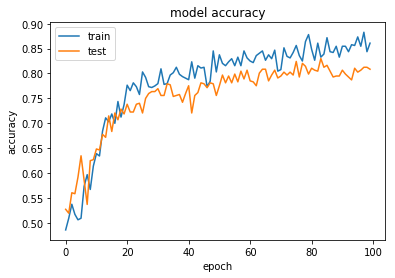

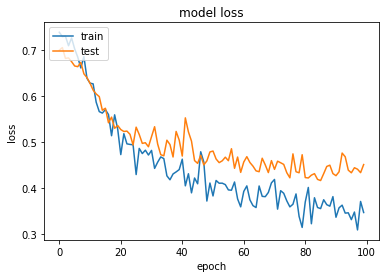

In [27]:
Baseline.validation_accuracy_loss(h_clf)

In [28]:
result = { }

#### train

In [29]:
number_of_pairs_train = int(len(baseline.test_data) * 0.1)

In [30]:
title_a, title_a_seg, title_b, title_b_seg, desc_a, desc_a_seg, desc_b, desc_b_seg, info_a, info_b, topic_a, topic_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, bug_train_ids, 
                                                                             number_of_pairs_train, 1)

y_true = sim
y_scores = model_clf.predict([title_a_seg, title_a, 
                              title_b_seg, title_b, 
                              desc_a_seg, desc_a, 
                              desc_b_seg, desc_b, 
                              info_a, info_b, 
                              topic_a, topic_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores_train = [ decode_ohe(r) for r in y_scores ]
y_true_train = [ decode_ohe(r) for r in y_true ]

#### test

In [31]:
number_of_pairs = len(baseline.test_data)

title_a, title_a_seg, title_b, title_b_seg, desc_a, desc_a_seg, desc_b, desc_b_seg, info_a, info_b, topic_a, topic_b, sim = experiment.batch_classification_test(TEST_PATH, BERT=True, TOPIC=True)

y_true = sim
y_scores = model_clf.predict([title_a_seg, title_a, 
                              title_b_seg, title_b, 
                              desc_a_seg, desc_a, 
                              desc_b_seg, desc_b, 
                              info_a, info_b,
                              topic_a, topic_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores_test = [ decode_ohe(r) for r in y_scores ]
y_true_test = [ decode_ohe(r) for r in y_true ]

In [32]:
# y_true_train = [[1], [1], [0], [0]]
# y_scores_train = [[1], [1], [1], [0]]

# y_true_test = [[1], [1], [0], [0]]
# y_scores_test = [[1], [1], [1], [0]]

### Accuracy

In [33]:
acc_train = accuracy_score(y_true_train, y_scores_train)
print("acc_train", acc_train)

acc_train 0.8902439024390244


In [34]:
acc_test = accuracy_score(y_true_test, y_scores_test)
print("acc_test", acc_test)

acc_test 0.798712342079689


### Roc AUC/SCORE

#### train

In [35]:
roc_train = roc_auc_score(y_true_train, y_scores_train)
print("roc_train", roc_train)

roc_train 0.8902439024390245


#### test

In [36]:
roc_test = roc_auc_score(y_true_test, y_scores_test)
print("roc_test", roc_test)

roc_test 0.798712342079689


### Save results for each instance tested

In [37]:
print(len(y_scores_test), len(y_true_test))

8232 8232


In [38]:
print(DIR, SAVE_PATH.replace('({})'.format(DOMAIN), ''))

data/processed/openoffice/bert deepQL_topics_1000_classification


In [39]:
def save_result(result):
    name = SAVE_PATH.replace('({})'.format(DOMAIN), '')
    with open(os.path.join(DIR,'{}.pkl'.format(name)), 'wb') as f:
        pickle.dump(result, f)
    print("=> saved result for classification by instance!")

In [40]:
acc = [int(x == y) for x, y in zip(y_scores_test, y_true_test)]

In [41]:
save_result({ 'y_pred' : y_scores_test, 'y_true' : y_true_test, 'acc' : acc })

=> saved result for classification by instance!


#### Save the model

In [43]:
experiment.save_model(model_clf, SAVE_PATH)

In [44]:
y_scores_test

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [45]:
# pred = np.argmax(y_scores_test, axis=1)
pred = y_scores_test #pred.tolist()
pred

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [46]:
#label = np.argmax(y_true_test, axis=1)
label = y_true_test #label.tolist()
label

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


Normalized confusion matrix
[[0.72886297 0.27113703]
 [0.13143829 0.86856171]]


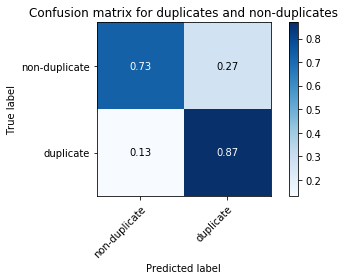

resultados/classification_openoffice_deepQL_topics_1000.png


In [47]:
ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['non-duplicate', 'duplicate']), 
                      title='Confusion matrix for duplicates and non-duplicates', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}.png'.format(DOMAIN, METHOD), bbox_inches="tight")
print('resultados/classification_{}_{}.png'.format(DOMAIN, METHOD))

Normalized confusion matrix
[[0.72886297 0.27113703]
 [0.13143829 0.86856171]]


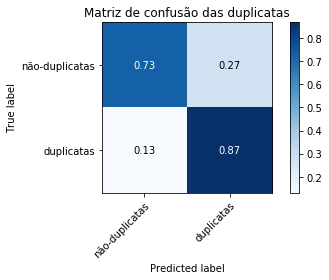

resultados/classification_openoffice_deepQL_topics_1000_pt.png


In [48]:
ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['não-duplicatas', 'duplicatas']), 
                      title='Matriz de confusão das duplicatas', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}_pt.png'.format(DOMAIN, METHOD), bbox_inches="tight")
print('resultados/classification_{}_{}_pt.png'.format(DOMAIN, METHOD))

#### Saving the accuracy and roc/auc

In [49]:
CLASSIFICATION_PATH = 'classification_{}.pkl'.format(METHOD)

def save_result(result):
    result = {
        'acc_train' : acc_train,
        'acc_test' : acc_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
        'method' : METHOD
    }

    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'wb') as f:
        pickle.dump(result, f)
        
print(CLASSIFICATION_PATH)

classification_deepQL_topics_1000.pkl


In [50]:
try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

All saved.


In [51]:
try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

All saved.


In [52]:
print(result)

{'acc_test': 0.798712342079689, 'acc_train': 0.8902439024390244, 'roc_train': 0.8902439024390245, 'roc_test': 0.798712342079689, 'method': 'deepQL_topics_1000'}
